In [7]:
import polars as pl

class FlightFeatureEngineer:
    def __init__(self, file_path):
        """Initialize with the file path."""
        self.file_path = file_path
        self.df = None

# Cell 1
    def load_data(self):
        """Load dataset."""
        self.df = pl.read_csv(self.file_path)

# Cell 2
    def convert_month_to_season(self):
        """Convert MONTH to SEASON (1: Winter, 2: Spring, 3: Summer, 4: Fall)."""
        self.df = self.df.with_columns(
            ((self.df["MONTH"] <= 3).cast(pl.Int64) * 1 +
             ((self.df["MONTH"] > 3) & (self.df["MONTH"] <= 6)).cast(pl.Int64) * 2 +
             ((self.df["MONTH"] > 6) & (self.df["MONTH"] <= 9)).cast(pl.Int64) * 3 +
             ((self.df["MONTH"] > 9)).cast(pl.Int64) * 4).alias("SEASON")
        )

# Cell 3
    def extract_departure_hour(self):
        """Extract departure hour from SCHEDULED_DEPARTURE."""
        self.df = self.df.with_columns((self.df["SCHEDULED_DEPARTURE"].floor().alias("DEPARTURE_HOUR")))

# Cell 4
    def compute_rolling_mean_delays(self):
        """Compute rolling mean delays for airlines, airports, and flights."""
        airline_delay = self.df.group_by("AIRLINE").agg(pl.col("DEPARTURE_DELAY").mean().alias("AVG_AIRLINE_DELAY"))
        airport_delay = self.df.group_by("ORIGIN_AIRPORT").agg(pl.col("DEPARTURE_DELAY").mean().alias("AVG_AIRPORT_DELAY"))
        flight_delay = self.df.group_by("FLIGHT_NUMBER").agg(pl.col("DEPARTURE_DELAY").mean().alias("AVG_FLIGHT_DELAY"))
        
        self.df = self.df.join(airline_delay, on="AIRLINE", how="left")
        self.df = self.df.join(airport_delay, on="ORIGIN_AIRPORT", how="left")
        self.df = self.df.join(flight_delay, on="FLIGHT_NUMBER", how="left")

# Cell 5
    def count_hourly_flights(self):
        """Count hourly departures and arrivals."""
        hourly_departures = self.df.group_by(["ORIGIN_AIRPORT", "DEPARTURE_HOUR"]).agg(pl.len().alias("HOURLY_DEPARTURES"))
        hourly_arrivals = self.df.group_by(["DESTINATION_AIRPORT", "SCHEDULED_ARRIVAL"]).agg(pl.len().alias("HOURLY_ARRIVALS"))
        
        self.df = self.df.join(hourly_departures, on=["ORIGIN_AIRPORT", "DEPARTURE_HOUR"], how="left")
        self.df = self.df.join(hourly_arrivals, on=["DESTINATION_AIRPORT", "SCHEDULED_ARRIVAL"], how="left")

# Cell 6
    def save_data(self, output_file):
        """Save cleaned dataset."""
        self.df.write_csv(output_file)
        print("Feature engineering complete! ✅")

    def show_head(self, n=5):
        """Show the first n rows of the dataset."""
        if self.df is not None:
            print(self.df.head(n))
        else:
            print("Data not loaded. Please run load_data() first.")

    def show_summary(self):
        """Show summary statistics of numerical columns."""
        if self.df is not None:
            print(self.df.describe())
        else:
            print("Data not loaded. Please run load_data() first.")

# Cell 7
    def process_features(self, output_file):
        """Execute the full feature engineering pipeline."""
        self.load_data()
        self.convert_month_to_season()
        self.extract_departure_hour()
        self.compute_rolling_mean_delays()
        self.count_hourly_flights()
        self.save_data(output_file)



In [9]:
# Cell 8
# Usage example
engineer = FlightFeatureEngineer("flights_cleaned.csv")
engineer.process_features("./flights_feture.csv")


Feature engineering complete! ✅


Explaroratry data analysis 

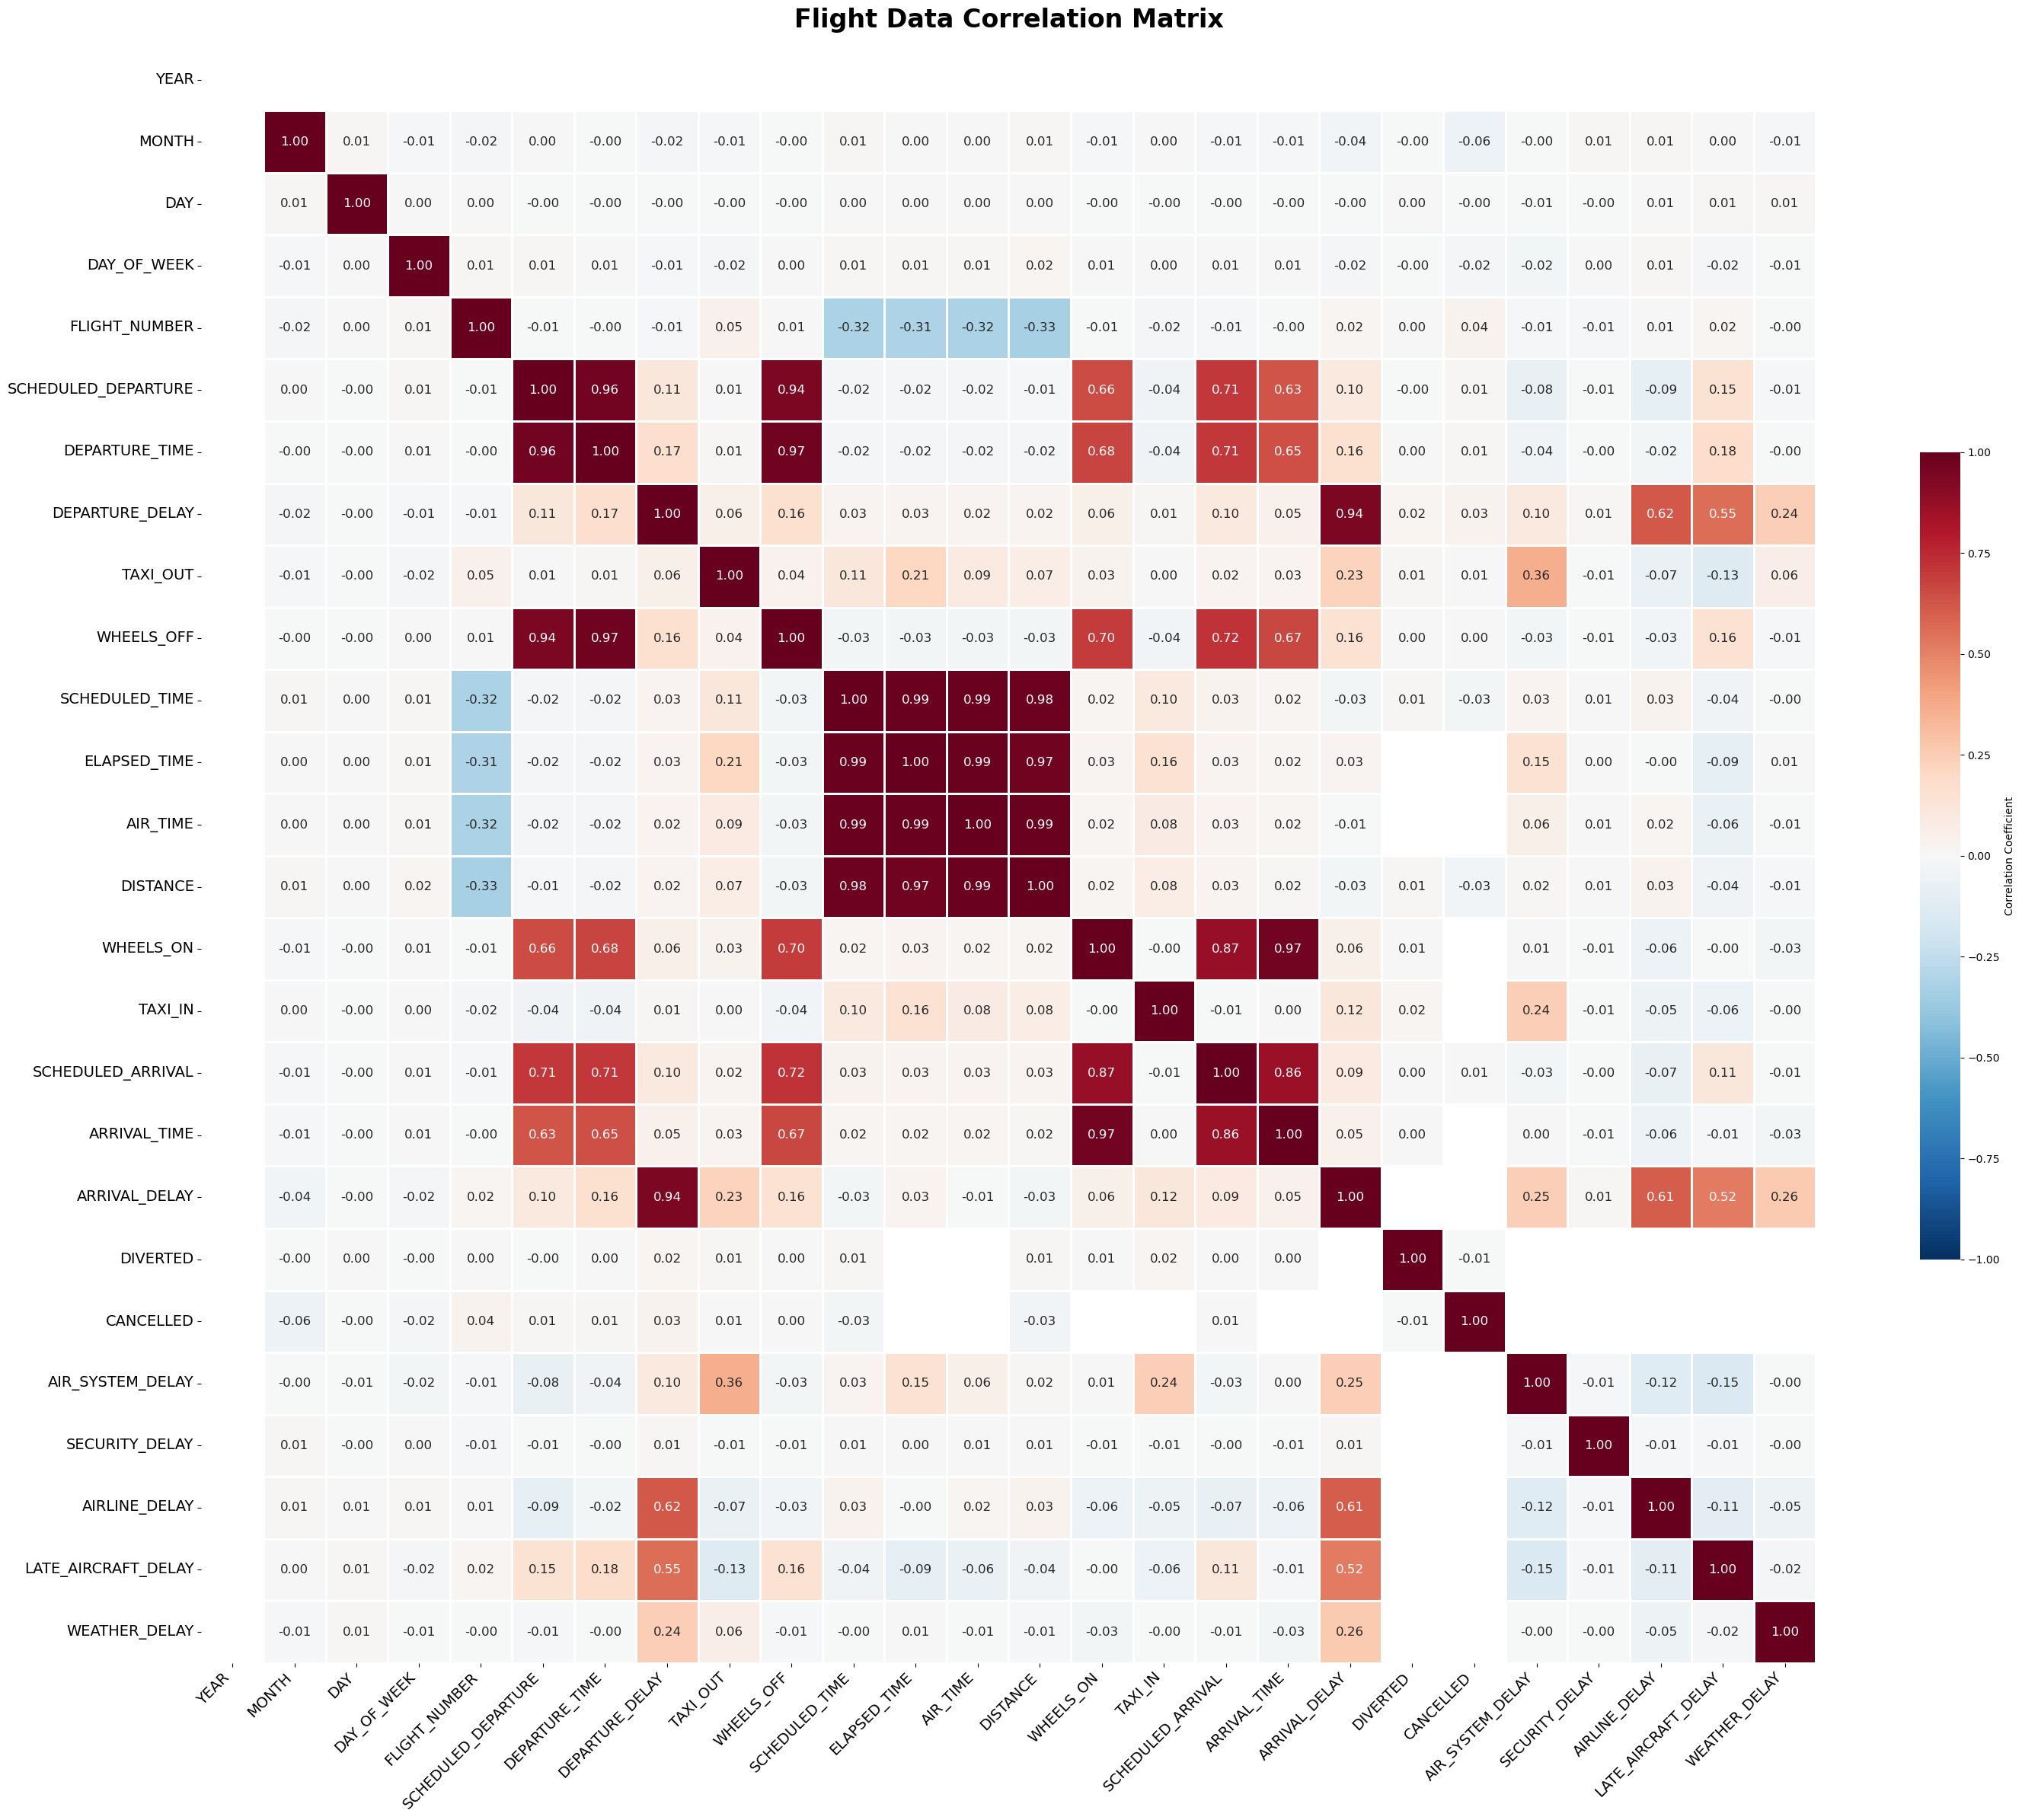

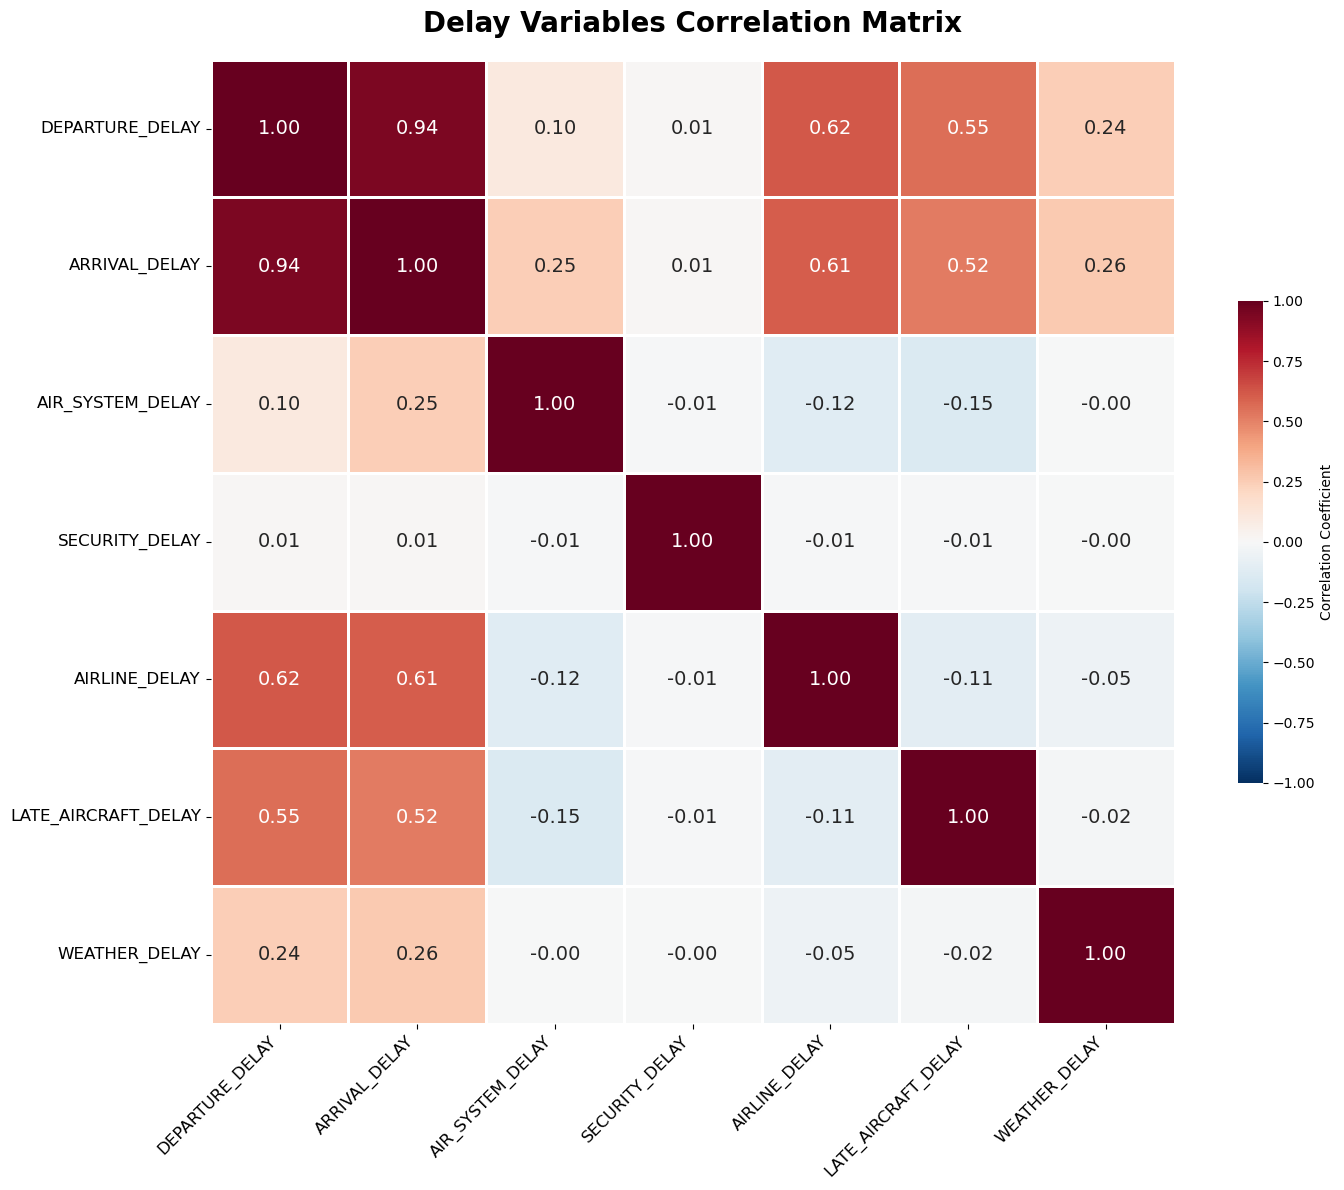

In [4]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def display_correlation_heatmap(file_path):
    # Read the data using polars
    df = pl.read_csv(file_path)
    
    # Select only numeric columns for correlation
    numeric_cols = [col for col in df.columns if df[col].dtype in [pl.Float64, pl.Int64]]
    correlation_df = df.select(numeric_cols).to_pandas().corr()

    # Set up the matplotlib figure with a very large size
    plt.figure(figsize=(30, 24))
    
    # Create the heatmap with improved formatting - removed the mask parameter
    sns.heatmap(correlation_df, 
                annot=True,
                cmap='RdBu_r',
                fmt='.2f',
                square=True,
                linewidths=1,
                cbar_kws={"shrink": .5, "label": "Correlation Coefficient"},
                annot_kws={'size': 12},
                vmin=-1, 
                vmax=1)

    # Improve label visibility
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    # Add title and adjust layout
    plt.title("Flight Data Correlation Matrix", pad=20, size=24, fontweight='bold')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Display the plot
    plt.show()

def display_subset_correlation_heatmap(file_path, variables_of_interest):
    # Read the data using polars
    df = pl.read_csv(file_path)
    
    # Calculate correlation for subset of variables
    correlation_df = df.select(variables_of_interest).to_pandas().corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 12))
    
    # Create the heatmap - removed the mask parameter here as well
    sns.heatmap(correlation_df, 
                annot=True,
                cmap='RdBu_r',
                fmt='.2f',
                square=True,
                linewidths=1,
                cbar_kws={"shrink": .5, "label": "Correlation Coefficient"},
                annot_kws={'size': 14},
                vmin=-1, 
                vmax=1)

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.title("Delay Variables Correlation Matrix", pad=20, size=20, fontweight='bold')
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Usage
file_path = "./flights.csv"

# Display full correlation matrix
display_correlation_heatmap(file_path)

# Display subset correlation matrix for key delay-related variables
delay_variables = [
    "DEPARTURE_DELAY",
    "ARRIVAL_DELAY",
    "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY",
    "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY"
]
display_subset_correlation_heatmap(file_path, delay_variables)



In [10]:
# Show the first few rows
engineer.show_head(10)  # Show first 10 rows

# Show dataset summary statistics
engineer.show_summary()

shape: (10, 36)
┌──────┬───────┬─────┬─────────────┬───┬───────────────────┬──────────────────┬───────────────────┬─────────────────┐
│ YEAR ┆ MONTH ┆ DAY ┆ DAY_OF_WEEK ┆ … ┆ AVG_AIRPORT_DELAY ┆ AVG_FLIGHT_DELAY ┆ HOURLY_DEPARTURES ┆ HOURLY_ARRIVALS │
│ ---  ┆ ---   ┆ --- ┆ ---         ┆   ┆ ---               ┆ ---              ┆ ---               ┆ ---             │
│ i64  ┆ i64   ┆ i64 ┆ i64         ┆   ┆ f64               ┆ f64              ┆ u32               ┆ u32             │
╞══════╪═══════╪═════╪═════════════╪═══╪═══════════════════╪══════════════════╪═══════════════════╪═════════════════╡
│ 2015 ┆ 10    ┆ 2   ┆ 5           ┆ … ┆ 0.808846          ┆ 0.838239         ┆ 130               ┆ 15              │
│ 2015 ┆ 1     ┆ 20  ┆ 2           ┆ … ┆ 0.920637          ┆ 0.521591         ┆ 1865              ┆ 8               │
│ 2015 ┆ 4     ┆ 21  ┆ 2           ┆ … ┆ 0.925535          ┆ 0.740039         ┆ 183               ┆ 70              │
│ 2015 ┆ 7     ┆ 24  ┆ 5           ┆ … ┆

In [11]:
# Duck db

In [13]:
import duckdb

con = duckdb.connect(database=':memory:')  # Or your database file

try:
    # Load data (replace 'flights_featured.csv' with your actual file path)
    con.execute("CREATE TABLE flights AS SELECT * FROM read_csv_auto('flights_feture.csv')")

    # 1. Average Departure Delay
    avg_delay = con.execute("SELECT AVG(DEPARTURE_DELAY) AS avg_departure_delay FROM flights").fetchdf()
    print("\n1. Average Departure Delay:")
    print(avg_delay)

    # 2. Number of Flights per Airline
    flights_per_airline = con.execute("SELECT AIRLINE, COUNT(*) AS num_flights FROM flights GROUP BY AIRLINE ORDER BY num_flights DESC").fetchdf()
    print("\n2. Number of Flights per Airline:")
    print(flights_per_airline)

    # 3. Top 10 Busiest Airports (by departures)
    busiest_airports = con.execute("SELECT ORIGIN_AIRPORT, COUNT(*) AS num_departures FROM flights GROUP BY ORIGIN_AIRPORT ORDER BY num_departures DESC LIMIT 10").fetchdf()
    print("\n3. Top 10 Busiest Airports:")
    print(busiest_airports)

    # 4. Average Arrival Delay by Destination Airport
    avg_arrival_delay = con.execute("SELECT DESTINATION_AIRPORT, AVG(ARRIVAL_DELAY) AS avg_arrival_delay FROM flights GROUP BY DESTINATION_AIRPORT ORDER BY avg_arrival_delay DESC").fetchdf()
    print("\n4. Average Arrival Delay by Destination Airport:")
    print(avg_arrival_delay)

    # 11.  Average Departure Delay by Origin Airport
    delay_by_origin = con.execute("SELECT ORIGIN_AIRPORT, AVG(DEPARTURE_DELAY) AS avg_delay FROM flights GROUP BY ORIGIN_AIRPORT ORDER BY avg_delay DESC").fetchdf()
    print("\n5. Average Departure Delay by Origin Airport:")
    print(delay_by_origin)

    # 12. Average Arrival Delay by Airline
    arrival_delay_by_airline = con.execute("SELECT AIRLINE, AVG(ARRIVAL_DELAY) AS avg_arrival_delay FROM flights GROUP BY AIRLINE ORDER BY avg_arrival_delay DESC").fetchdf()
    print("\n6. Average Arrival Delay by Airline:")
    print(arrival_delay_by_airline)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    con.close()
    print("\nConnection closed.")


1. Average Departure Delay:
   avg_departure_delay
0             0.915799

2. Number of Flights per Airline:
    AIRLINE  num_flights
0         0       236626
1         1       130279
2        10       118023
3         6       109184
4        12       107795
5         4       104722
6         9        60547
7         3        59175
8        11        36549
9         2        34221
10       13        23570
11        5        22352
12        7        11778
13        8         8618

3. Top 10 Busiest Airports:
   ORIGIN_AIRPORT  num_departures
0             395           66663
1             553           56462
2             462           50478
3             149           43331
4             567           40281
5             486           30690
6              14           29534
7             434           27427
8             292           27225
9             313           22709

4. Average Arrival Delay by Destination Airport:
     DESTINATION_AIRPORT  avg_arrival_delay
0                 